# Загрузка данных и библиотек

In [157]:
#pip install transformers
#pip install sklearn
#pip install tensorflow

In [158]:
import tensorflow as tf
from tensorflow import keras, feature_column

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras import layers

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Последовательная модель НС
from tensorflow.keras.models import Sequential  
# Основные слои
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization 
# Утилиты для to_categorical()
from tensorflow.keras import utils   
# Алгоритмы оптимизации для обучения модели
from tensorflow.keras.optimizers import Adam, Adadelta   
# Связь с google-диском
from google.colab import files   
# Предварительная обработка данных
from sklearn import preprocessing         
# Для загрузки датасета
from keras.datasets import fashion_mnist                   

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline


mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

file_path = 'chd_addmit_300.xlsx'
dataframe = pd.read_excel(file_path).drop(['birth','admittion',	'discharge', 'Дата опер.'], axis=1)

# этот признак работает криво. исправлю здесь
dataframe['sex'] = dataframe['sex'].apply(lambda x: 1 if x=='f' else 0)

# Входной пайплайн df_to_dataset. Подготовка датасета. Предобработка. Сплит на выборки

Первый шаг заключается в преобразовании датафреймов Pandas в наборы данных TensorFlow:

In [159]:
# Вспомогательный метод для создания tf.data dataset из датафрейма Pandas
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Делаем заглушки
for col in dataframe.columns.tolist():
  if dataframe[col].dtypes in ['float64', 'int64']:
    dataframe[col] = dataframe[col].fillna(dataframe[col].median())

for col in dataframe.columns.tolist():
  if dataframe[col].dtypes == 'object':
    dataframe[col] = dataframe[col].fillna('Нет данных')

# Разделяем на выборки

# вариант разделения по туториалам. пусть будет пока
#train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

X_train, X_test, y_train, y_test = train_test_split(dataframe, dataframe['target'], 
                                                      test_size=0.2, 
                                                      random_state=5,
                                                      stratify=dataframe['target'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=0.2, 
                                                      random_state=5,
                                                      stratify=y_train)

# Преобразуем датафрейм Pandas в наборы данных TensorFlow
batch_size = 256
train_ds = df_to_dataset(X_train, batch_size=batch_size)
val_ds = df_to_dataset(X_val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(X_test, shuffle=False, batch_size=batch_size)

<ipython-input-159-6a0b75ab49dc>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
<ipython-input-159-6a0b75ab49dc>:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


Здесь стоит обратить внимание на то, что наборы данных TensorFlow и результаты дальнейших преобразований данных не хранятся в памяти так же, как хранятся датафреймы Pandas. Они, по сути, представляют собой конвейер. Через него, пакет за пакетом, походят данные, что позволяет модели эффективно обучаться на наборах данных, которые слишком велики для размещения их в памяти. Именно поэтому мы преобразуем в наборы данных словари датафреймов, а не реальные данные. Обратите внимание на то, что мы, кроме прочего, задаём сейчас, а не во время обучения модели, размер пакета данных, поступая не так, как обычно поступают при использовании API Keras.

## Пример работы пайплайна

In [169]:
for feature_batch, label_batch in train_ds.take(1):
  print('Все признаки:', list(feature_batch.keys()))
  print('Батч height:', feature_batch['height'][:5]) # 18 значений из 35 уникальных. сократил до 5, для удобства
  print('Батч targets:', label_batch )

Все признаки: ['sex', 'height', 'weight', 'BMI', 'BSA', 'Операции (все в ИБ)', 'Перенесенные опер. (из Анамн.)', 'Диагноз', 'МКБ', 'Соп. забол. (из Анамн.)', 'Медикам. леч. по поводу осн. забол. (из Анамн.)', 'Принимаемые препараты (из Анамн.)', 'ЭхоКГ (Из Эпикр. до опер.)', 'ЭКГ (Из Эпикр. до опер.)', 'АКГ (Из Эпикр. до опер.)', 'КТ (Из Эпикр. до опер.)', 'Операция (основная / первая в ИБ)', 'target']
Батч height: tf.Tensor(
[[67]
 [74]
 [64]
 [59]
 [58]], shape=(5, 1), dtype=int64)
Батч targets: tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0], shape=(192,), dtype=int64)


## Нормализация входных/выходных данных. (Пока не используется!)

In [ ]:
# предобработка слоя с числовыми призанками
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

# предобработка слоя с категориальными призанками
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

all_inputs = []
encoded_features = []

# Numerical features.
for header in dataframe.columns.tolist():
  if dataframe[header].dtypes in ['float64', 'int64']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

# Сategorical features.
categorical_cols = dataframe.columns.tolist()
for header in categorical_cols:
  if dataframe[col].dtypes == 'object':
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=train_ds,
                                                dtype='string',
                                                max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

#all_features = tf.keras.layers.concatenate(encoded_features)
#x = tf.keras.layers.Dense(32, activation="relu")(all_features)
#x = tf.keras.layers.Dropout(0.5)(x)
#output = tf.keras.layers.Dense(1)(x)

#model = tf.keras.Model(all_inputs, output)

# Слой feature_columns с размеченными призаками.

Теперь создадим список уникальных значений. Эти материалы мы используем позже, создавая и извлекая эмбеддинги.

In [162]:
feature_columns = []
# передаём модели числовые признаки:
for col in dataframe.drop('target', axis=1).columns.tolist():
  if dataframe[col].dtypes in ['float64', 'int64']:
    feature_columns.append(tf.feature_column.numeric_column(col))

# передаём модели категориальные признаки:
for col in dataframe.loc[:,dataframe.dtypes == 'object'].columns.tolist():
  # группировка. создаём список уникальных значений признака
  unique_list = X_train[col].unique()
  # создаём категориальный столбец с использованием ранее созданного списка:
  cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
    col, unique_list)
  # Далее работаем с будущими эмбеддингами. Cтолбцы векторных представлений
  if len(dataframe[col].unique()) > 5:
    # dimension - количество признаков из эмбеддинга. Обычно это 4 степень корня от числа уникальных призаков
    dimension = round(len(dataframe[col].unique())**0.25)
    # создаём эмбеддинг из категориального столбца:
    cat_emb = tf.feature_column.embedding_column(cat_col,dimension=dimension)
    # добавляем эмбеддинг в список столбцов признаков:
    feature_columns.append(cat_emb)
  else:
    # представление строк в виде one-hot для простого категориального признака
    cat_col = feature_column.indicator_column(cat_col)
    # добавляем категориальный признак в список столбцов признаков:
    feature_columns.append(cat_col)


**Числовой столбец (numeric column)** простейший вид столбца. Он используется для представления числовых признаков. При использовании этого столбца модель получает столбец значений из датафрейма без изменений.

**Категориальные столбцы (categorical columns)**
Мы не можем передать строки напрямую в модель. Вместо этого мы должны сперва поставить им в соответствие численные значения. Словарь категориальных столбцов (categorical vocabulary columns) обеспечивает способ представления строк в виде one-hot векторов. Справочник может быть передан как список с использованием categorical_column_with_vocabulary_list, или загружен из файла с использованием categorical_column_with_vocabulary_file.

**Столбцы векторных представлений (embedding column)**
Предположим, что вместо нескольких возможных строковых значений мы имеем тысячи и более значений для категорий. По ряду причин когда число категорий сильно вырастает, становится невозможным обучение нейронной сети с использованием one-hot кодирования. Мы можем использовать столбец векторных представлений для преодоления этого ограничения. Вместо представления данных в виде многомерных one-hot векторов столбец векторных представлений представляет эти данные в виде плотных векторов меньшей размерности, в которых в каждой ячейке может содержаться любое число, а не только О или 1.

Ключевой момент: использование столбца векторных представлений лучше всего, когда у категориального столбца много возможных значений. Здесь мы используем его только для демонстрационных целей, чтобы у вас был полный пример, который можно использовать в будущем для другого набора данных.

## Создаем новые комбинированные признаки

In [163]:
# Новый признак. столбeц пересечения свойств.
def new_feature(data_columns_list = dataframe.columns.tolist()):
  с_columns = []
  for col in dataframe.columns.tolist():
    # num c
    if dataframe[col].dtypes in ['float64', 'int64']:
      num_cal = feature_column.bucketized_column(feature_column.numeric_column(col), 
                                                        boundaries=dataframe[col].sort_values().unique().tolist())
      с_columns.append(num_cal)
    # cat c
    if dataframe[col].dtypes in ['object'] and len(dataframe[col].unique()) < 5:
      cat_col = feature_column.categorical_column_with_vocabulary_list(
            col, dataframe[col].unique().tolist())
      с_columns.append(cat_col)

  crossed_feature = feature_column.crossed_column(с_columns, hash_bucket_size=1000)
  crossed_feature = feature_column.indicator_column(crossed_feature)
  return crossed_feature

#new_c_f = new_feature(dataframe.columns.tolist())
#feature_columns.append(new_c_f)

**Пересеченные столбцы признаков (crossed feature columns)**
Комбинирование признаков в один больше известное как пересечение признаков, позволяет модели изучать отдельные веча для каждой комбинации свойств. crossed_column не строит полную таблицу комбинаций значений признаков (которая может быть очень большой). Вместо этого он поддерживает hashed_column так что можно самому выбирать размер таблицы.

# Обучение

Здесь главное правильно указать первый слой (наши признаки) и последний (количество классов в таргете). Но тк их всего два то можно указать единицу, что я и сделал. Все остальное завист от уровня знаний и предпочтений. Нужно экспериментировать

In [ ]:
%%time
model = Sequential() # создаем модель

model.add(tf.keras.layers.DenseFeatures(feature_columns)) # входной. слой признаков
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))                   # боремся с переобучением
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())           # боремся с переобучением
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # выходной слой

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
                        validation_data=val_ds,
                        batch_size=50, 
                        epochs=10,
                        validation_split=0.2,
                        verbose=1)

scores = model.evaluate(test_ds, verbose=1)


Обычно в нейронке бинарная задача решается с метрикой `accuracy`. Но как мы знаем, она плохо работает с несбаланированными классами. Буду думать, на что поменять

In [165]:
# Схема архитектуры. Пока не работает как нужно. Разбираюсь с этим
# Use `rankdir='LR'` to make the graph horizontal.
# tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# Тест

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features_14 (DenseFea  multiple                 5412      
 tures)                                                          
                                                                 
 dense_40 (Dense)            multiple                  6144      
                                                                 
 dropout_10 (Dropout)        multiple                  0         
                                                                 
 dense_41 (Dense)            multiple                  8256      
                                                                 
 batch_normalization_10 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 dense_42 (Dense)            multiple                

None

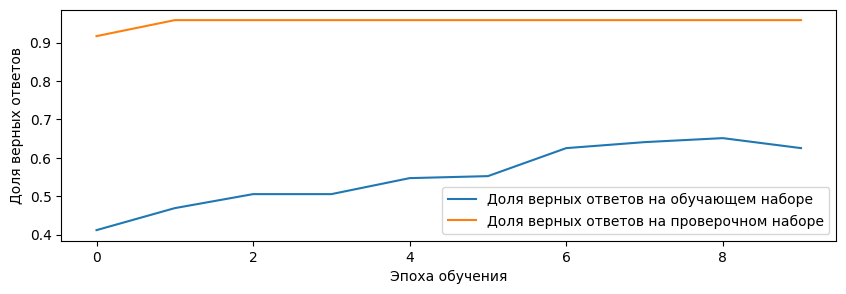

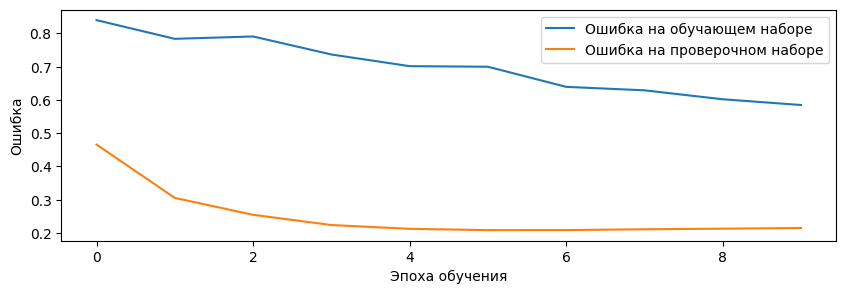

Доля верных ответов на тестовых данных, в процентах: 0.95


In [171]:
# Краткая сводка архитектуры модели
display(model.summary())

plt.figure(figsize=(10,3)) 
plt.plot(history.history['accuracy'], 
            label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
            label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

plt.figure(figsize=(10,3)) 
plt.plot(history.history['loss'], 
            label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
            label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

# Вычисление результата (предсказания) сети на тестовом наборе
print(f'Доля верных ответов на тестовых данных, в процентах: {round(scores[1],2)}')
